In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# To save models
from joblib import dump

1.4.1.post1


## Loading the data

In [2]:
# weather data
weather = pd.read_csv('data/weather.csv')
# keep only useful columns
columns = ["timestamp", "temp", "pressure", "cloudiness", "humidity_relative"]
weather = weather[columns]
weather.head()

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8


In [3]:
# sunrise-sunset data
sun = pd.read_excel('data/sunrise-sunset.xlsx')
sun.head()

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [4]:
# solar data
solar = pd.read_csv('data/solar.csv')
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,1.02
2,2023-03-11 18:00:10.284064+01,1.17
3,2023-03-11 19:00:10.224836+01,1.18
4,2023-03-11 20:00:10.201847+01,1.18


## Take a quick look at the data structure of every data set

### weather

In [5]:
weather.head()

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8


Observation:
- one row in every four rows in the data set represents the measurements of one weahter station at one timestamp

In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          39840 non-null  object 
 1   temp               39840 non-null  float64
 2   pressure           39828 non-null  float64
 3   cloudiness         15455 non-null  float64
 4   humidity_relative  29880 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.5+ MB


Observation:
- cloudiness and humidity_relative have a lot of null values

In [7]:
weather.describe()

,temp,pressure,cloudiness,humidity_relative
count,39840.000000,39828.000000,15455.000000,29880.000000
mean,11.857083,1013.377732,5.490780,81.043618
std,5.858675,11.320142,2.583189,13.898511
min,-5.900000,965.100000,0.000000,24.700000
25%,8.200000,1007.200000,4.000000,72.500000
50%,11.200000,1014.700000,7.000000,84.200000
75%,15.900000,1021.200000,7.000000,92.000000
max,32.400000,1041.800000,8.000000,100.000000


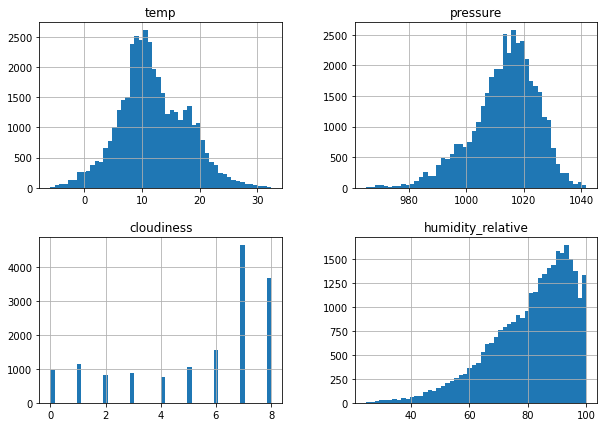

In [8]:
weather.hist(bins=50, figsize=(10,7))
plt.show()

Observations:
- cloudiness is categorical
- humidity_relative looks capped at 100

### solar

In [9]:
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  9705 non-null   object 
 1   kwh        9705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.8+ KB


In [10]:
solar.describe()

,kwh
count,9705.000000
mean,1401.190049
std,741.801205
min,0.000000
25%,772.572600
50%,1737.388200
75%,1964.015800
max,2417.478800


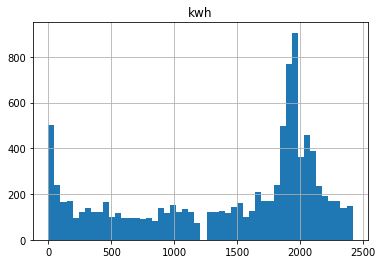

In [11]:
solar.hist(bins=50, figsize=(6, 4))
plt.show()

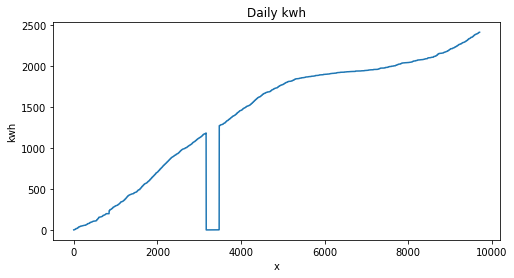

In [12]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(range(len(solar)), solar["kwh"])
plt.xlabel("x")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

Observations:
- kwh is a cumulative value
- there are outliers

### sunrise-sunset

In [13]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datum           731 non-null    datetime64[ns]
 1   Opkomst         731 non-null    object        
 2   Op ware middag  731 non-null    object        
 3   Ondergang       731 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.0+ KB


In [14]:
sun[["Opkomst", "Op ware middag", "Ondergang"]].describe()

,Opkomst,Op ware middag,Ondergang
count,731,731,731
unique,195,56,283
top,05:29:00,13:39:00,16:37:00
freq,24,51,20


### merge weahter and solar datasets into one

In [15]:
print(len(weather))
weather = weather.groupby("timestamp").mean().reset_index()
print(len(weather))

39840
9960


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          9960 non-null   object 
 1   temp               9960 non-null   float64
 2   pressure           9960 non-null   float64
 3   cloudiness         9960 non-null   float64
 4   humidity_relative  9960 non-null   float64
dtypes: float64(4), object(1)
memory usage: 389.2+ KB


In [17]:
# merge weather and solar
weather["timestamp"] = pd.to_datetime(weather["timestamp"], utc=True)
solar["timestamp"] = pd.to_datetime(solar["timestamp"], utc=True)
data = pd.merge_asof(solar, weather, on="timestamp", direction="nearest")

In [18]:
data.shape

(9705, 6)

In [19]:
data.head()

,timestamp,kwh,temp,pressure,cloudiness,humidity_relative
0,2023-03-11 15:00:10.160454+00:00,0.54,6.85,1012.025,6.0,54.833333
1,2023-03-11 16:00:10.217795+00:00,1.02,6.30,1011.625,7.0,57.800000
2,2023-03-11 17:00:10.284064+00:00,1.17,5.95,1011.500,7.0,60.366667
3,2023-03-11 18:00:10.224836+00:00,1.18,5.25,1011.850,7.0,64.500000
4,2023-03-11 19:00:10.201847+00:00,1.18,4.85,1011.650,7.0,68.633333


In [20]:
# clean weather timestamp data
data["timestamp"] = data["timestamp"].apply(lambda date: pd.to_datetime(date).strftime("%Y-%m-%d %H"))
# split timestamp into date and hour
data["date"] = data["timestamp"].apply(lambda date: date.split(" ")[0])
data["hour"] = data["timestamp"].apply(lambda date: date.split(" ")[1])
data.drop(columns=["timestamp"], inplace=True)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15
1,1.02,6.30,1011.625,7.0,57.800000,2023-03-11,16
2,1.17,5.95,1011.500,7.0,60.366667,2023-03-11,17
3,1.18,5.25,1011.850,7.0,64.500000,2023-03-11,18
4,1.18,4.85,1011.650,7.0,68.633333,2023-03-11,19


In [21]:
sun.rename(columns={"datum": "date", "Opkomst": "sunrise", "Op ware middag": "sun_noon", "Ondergang": "sunset"}, inplace=True)
# make date column a string
sun["date"] = sun["date"].apply(lambda date: date.strftime("%Y-%m-%d"))
sun.head()

,date,sunrise,sun_noon,sunset
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [22]:
# merge all data
data = data.merge(sun, on=["date"], how="inner")
print(data.shape)

(9705, 10)


In [23]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,07:06:00,12:53:00,18:40:00
1,1.02,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
2,1.17,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
3,1.18,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
4,1.18,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00


## Cleaning the data

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9705 entries, 0 to 9704
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kwh                9705 non-null   float64
 1   temp               9705 non-null   float64
 2   pressure           9705 non-null   float64
 3   cloudiness         9705 non-null   float64
 4   humidity_relative  9705 non-null   float64
 5   date               9705 non-null   object 
 6   hour               9705 non-null   object 
 7   sunrise            9705 non-null   object 
 8   sun_noon           9705 non-null   object 
 9   sunset             9705 non-null   object 
dtypes: float64(5), object(5)
memory usage: 834.0+ KB


In [25]:
data["date"] = pd.to_datetime(data["date"])

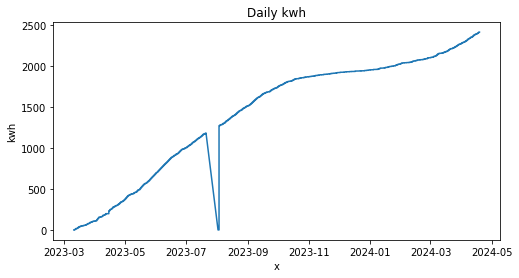

In [26]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(data["date"], data["kwh"])
plt.xlabel("x")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

In [27]:
# remove outliers
print(data.shape)
data = data[(data["date"] != "2023-08-02") & (data["date"] != "2023-08-03")]
print(data.shape)

(9705, 10)
(9382, 10)


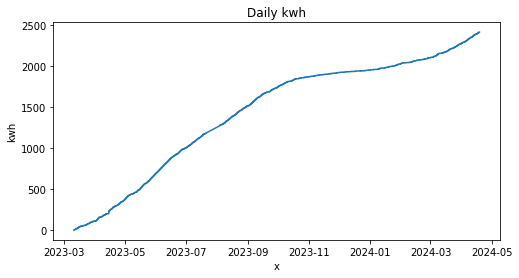

In [28]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(data["date"], data["kwh"])
plt.xlabel("x")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

In [29]:
# kwh is cummulative, make it hourly
data["kwh"] = data["kwh"] - data["kwh"].shift(1, fill_value=0)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,07:06:00,12:53:00,18:40:00
1,0.48,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
2,0.15,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
3,0.01,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
4,0.00,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00


<Axes: ylabel='kwh'>

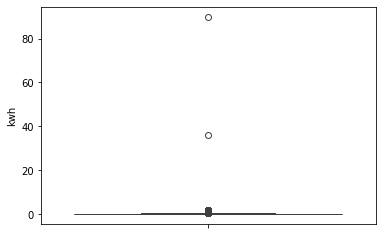

In [30]:
sns.boxplot(data["kwh"])

Observation:
- there are still outliers

In [31]:
def remove_outliers(df, col):
    mean = df[col].mean()
    std = data[col].std()
    return df[abs(df[col] - mean) < 3 * std]

In [32]:
print(data["kwh"].mean(), data["kwh"].std())

0.25767201023235975 1.0944543220890077


In [33]:
print(len(data))
# remove outliers
data = remove_outliers(data, "kwh")
print(len(data))
data.describe()

9382
9380


,kwh,temp,pressure,cloudiness,humidity_relative
count,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000
mean,0.244283,11.859731,1013.802559,5.392697,81.024012
std,0.450857,5.690816,11.293369,2.422875,12.760237
min,0.000000,-4.650000,967.800000,0.000000,31.366667
25%,0.000000,8.250000,1007.750000,3.500000,73.366667
50%,0.000000,11.150000,1015.475000,6.500000,84.233333
75%,0.248600,15.600000,1021.581250,7.000000,91.100000
max,2.098000,30.975000,1041.275000,8.000000,99.033333


In [34]:
print(data["kwh"].mean(), data["kwh"].std())

0.2442831663113006 0.4508573598238607


In [35]:
# change timestamps to difference in minutes from minimum timestamp
data["sunrise"] = data["sunrise"].apply(lambda time: time.hour * 60 + time.minute)
sunrise_min = data["sunrise"].min()
data["sunrise"] = data["sunrise"] - sunrise_min

data["sun_noon"] = data["sun_noon"].apply(lambda time: time.hour * 60 + time.minute)
sun_noon_min = data["sun_noon"].min()
data["sun_noon"] = data["sun_noon"] - sun_noon_min

data["sunset"] = data["sunset"].apply(lambda time: time.hour * 60 + time.minute)
sunset_min = data["sunset"].min()
data["sunset"] = data["sunset"] - sunset_min
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,97,27,123
1,0.48,6.30,1011.625,7.0,57.800000,2023-03-11,16,97,27,123
2,0.15,5.95,1011.500,7.0,60.366667,2023-03-11,17,97,27,123
3,0.01,5.25,1011.850,7.0,64.500000,2023-03-11,18,97,27,123
4,0.00,4.85,1011.650,7.0,68.633333,2023-03-11,19,97,27,123


In [36]:
# add month and day columns
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.dayofweek
# drop date column
data.drop("date", axis=1, inplace=True)
# convert hour to int
data["hour"] = data["hour"].astype("int")

## Date exploration

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9380 entries, 0 to 9704
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kwh                9380 non-null   float64
 1   temp               9380 non-null   float64
 2   pressure           9380 non-null   float64
 3   cloudiness         9380 non-null   float64
 4   humidity_relative  9380 non-null   float64
 5   hour               9380 non-null   int32  
 6   sunrise            9380 non-null   int64  
 7   sun_noon           9380 non-null   int64  
 8   sunset             9380 non-null   int64  
 9   month              9380 non-null   int64  
 10  day                9380 non-null   int64  
dtypes: float64(5), int32(1), int64(5)
memory usage: 842.7 KB


In [38]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,month,day
0,0.54,6.85,1012.025,6.0,54.833333,15,97,27,123,3,5
1,0.48,6.30,1011.625,7.0,57.800000,16,97,27,123,3,5
2,0.15,5.95,1011.500,7.0,60.366667,17,97,27,123,3,5
3,0.01,5.25,1011.850,7.0,64.500000,18,97,27,123,3,5
4,0.00,4.85,1011.650,7.0,68.633333,19,97,27,123,3,5


In [39]:
data.describe()

,kwh,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,month,day
count,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000
mean,0.244283,11.859731,1013.802559,5.392697,81.024012,11.564286,101.646269,51.001706,166.487100,6.184009,3.002132
std,0.450857,5.690816,11.293369,2.422875,12.760237,6.937187,60.713691,28.942723,108.579749,3.456281,2.004153
min,0.000000,-4.650000,967.800000,0.000000,31.366667,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,8.250000,1007.750000,3.500000,73.366667,6.000000,58.000000,25.000000,62.000000,3.000000,1.000000
50%,0.000000,11.150000,1015.475000,6.500000,84.233333,12.000000,102.000000,66.000000,164.000000,6.000000,3.000000
75%,0.248600,15.600000,1021.581250,7.000000,91.100000,18.000000,155.000000,77.000000,261.000000,9.000000,5.000000
max,2.098000,30.975000,1041.275000,8.000000,99.033333,23.000000,196.000000,83.000000,323.000000,12.000000,6.000000


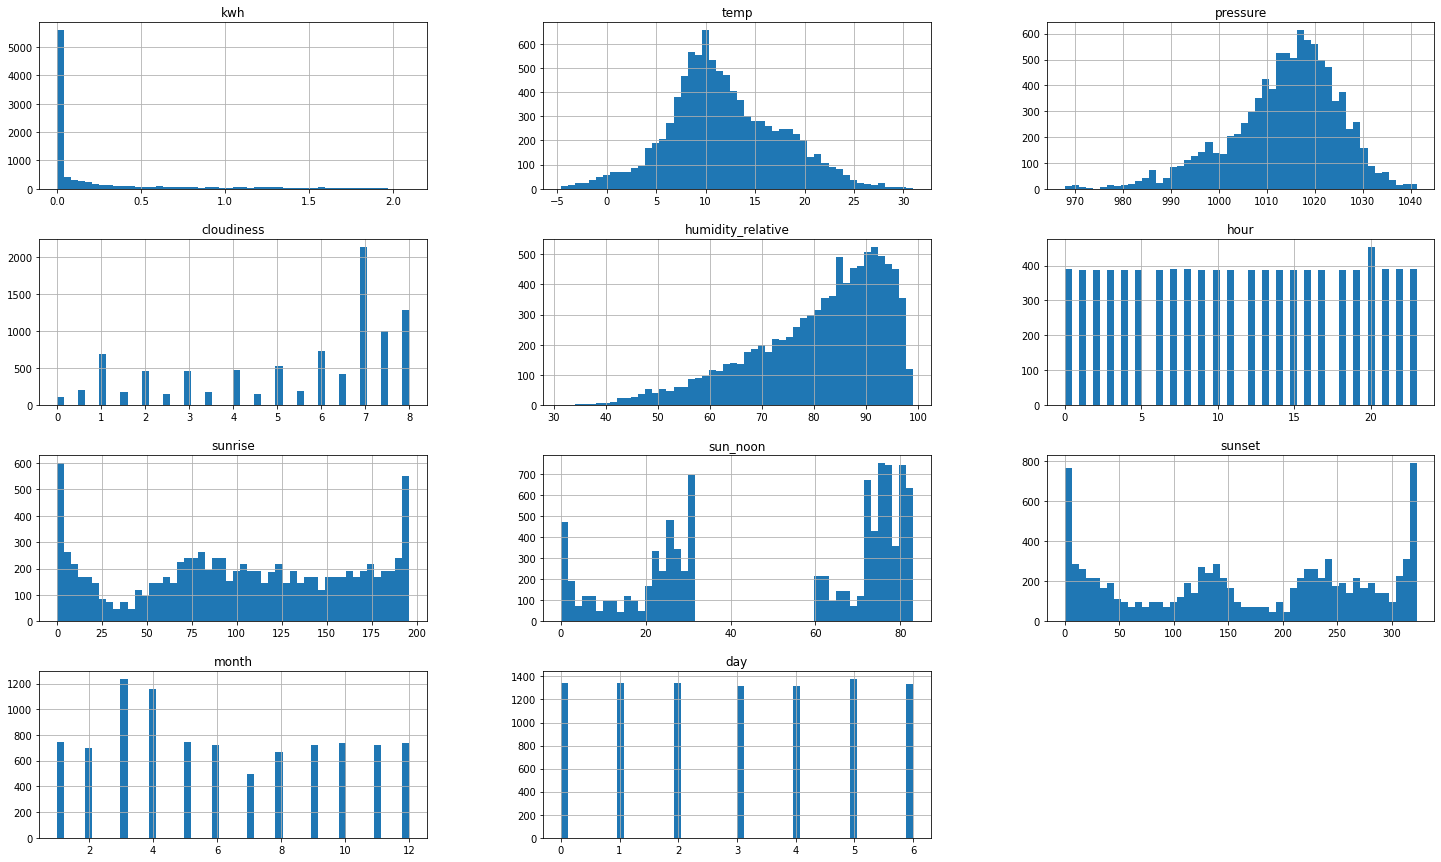

In [40]:
data.hist(bins=50, figsize=(25, 15))
plt.show()

Observations:
- kwh has a lot of 0 values
- month, day, hour and cloudiness are categorical

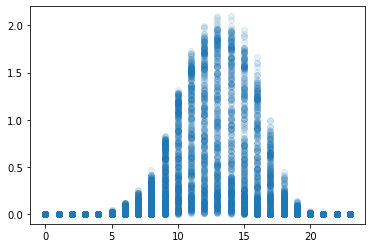

In [41]:
plt.scatter(data["hour"], data["kwh"], alpha=0.1)
plt.show()

Observation:
- kwh is clearly higher during the day

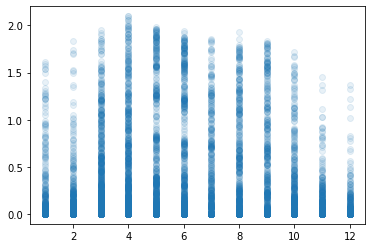

In [42]:
plt.scatter(data["month"], data["kwh"], alpha=0.1)
plt.show()

## Create a test set

In [43]:
X = data.drop(columns=["kwh"])
y = data["kwh"]

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(7504, 1876)

## Look for correlations

In [45]:
data = pd.concat([X_train, y_train], axis=1)

In [46]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kwh"].sort_values(ascending=False).round(2)

kwh                  1.00
temp                 0.42
sunset               0.30
sun_noon             0.26
pressure             0.15
hour                 0.09
day                 -0.01
month               -0.04
cloudiness          -0.27
sunrise             -0.28
humidity_relative   -0.64
Name: kwh, dtype: float64

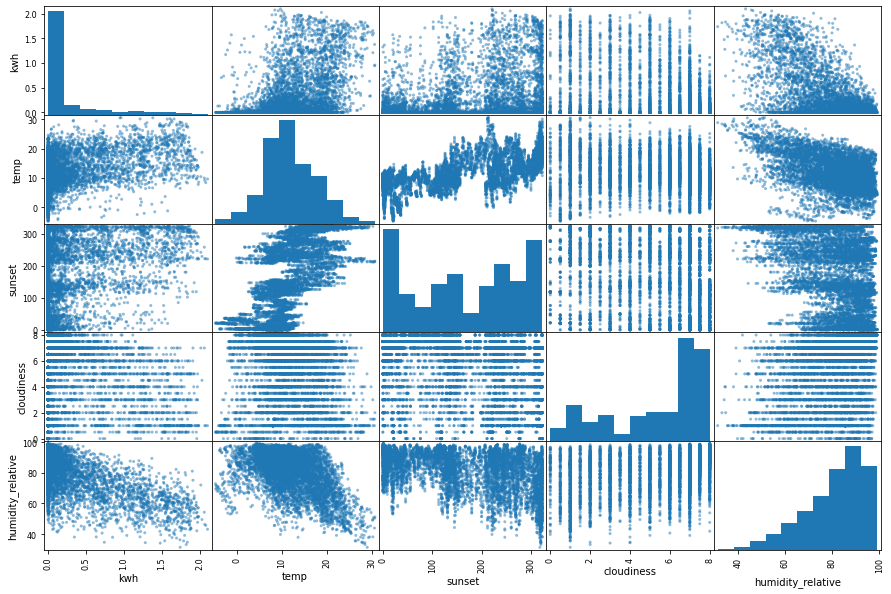

In [47]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "temp", "sunset", "cloudiness", "humidity_relative"]
scatter_matrix(data[attributes], figsize=(15, 10))
plt.show()

## Prepare the data

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 8420 to 7595
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp               7504 non-null   float64
 1   pressure           7504 non-null   float64
 2   cloudiness         7504 non-null   float64
 3   humidity_relative  7504 non-null   float64
 4   hour               7504 non-null   int32  
 5   sunrise            7504 non-null   int64  
 6   sun_noon           7504 non-null   int64  
 7   sunset             7504 non-null   int64  
 8   month              7504 non-null   int64  
 9   day                7504 non-null   int64  
dtypes: float64(4), int32(1), int64(5)
memory usage: 615.6 KB


In [49]:
# give categorical values their own type
X_train["month"] = X_train["month"].astype("category")
X_train["day"] = X_train["day"].astype("category")
X_train["hour"] = X_train["hour"].astype("category")
# X_train["cloudiness"] = X_train["cloudiness"].astype("category")

In [50]:
data_num_ix = X_train.select_dtypes(include=[np.number]).columns
data_cat_ix = X_train.select_dtypes(include=["category"]).columns
print("Numerical columns: ", data_num_ix)
print("Categorical columns: ", data_cat_ix)

Numerical columns:  Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'sunrise',
       'sun_noon', 'sunset'],
      dtype='object')
Categorical columns:  Index(['hour', 'month', 'day'], dtype='object')


In [51]:
# work in progress
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeDate(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        # X = check_array(X)
        return self

    def transform(self, X):
        assert "date" in self.feature_names_in_
        X = X.copy()
        X["date"] = pd.to_datetime(X["date"])
        X["month"] = X["date"].dt.month
        X["day"] = X["date"].dt.dayofweek
        X["month"] = X["month"].astype("category")
        X["day"] = X["day"].astype("category")
        X.drop("date", axis=1, inplace=True)
        return X

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# log_pipeline = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("log", FunctionTransformer(np.log, inverse_func=np.exp)),
#     ("standardize", StandardScaler())
# ])

cat_pipline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")), 
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, data_num_ix),
    ("cat", cat_pipline, data_cat_ix)
])

## Model selection

### Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func=np.square)

lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("lin_reg", TransformedTargetRegressor(LinearRegression(), transformer=sqrt_transformer))
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'sunrise',
       'sun_noon', 'sunset'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['hour', 'month', 'day'], dtype='object'))])),
                ('lin_reg',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [67]:
# cross validation for linear regression
from sklearn.model_selection import cross_val_score

scores = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=10)
print("Linear Regression cross validation MAE: ", scores.mean())

Linear Regression cross validation MAE:  0.10547953140625058


In [68]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

y_test_pred = lin_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print("Linear Regression RMSE on test set: ", rmse)
print("Linear Regression MAE on test set: ", mae)

Linear Regression RMSE on test set:  0.20953251540518023
Linear Regression MAE on test set:  0.10920635198377181


In [69]:
y_train_pred = lin_reg.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print("Linear Regression RMSE on train set: ", mae)

Linear Regression RMSE on train set:  0.10472146655702735


In [57]:
def plot_predictions(y_test, y_pred, size):
    plt.figure(figsize=(12, 6))
    size_range = range(size)
    plt.plot(size_range, y_test[:size], label="Actual")
    plt.plot(size_range, y_pred[:size], label="Predicted")
    plt.legend()
    plt.show()

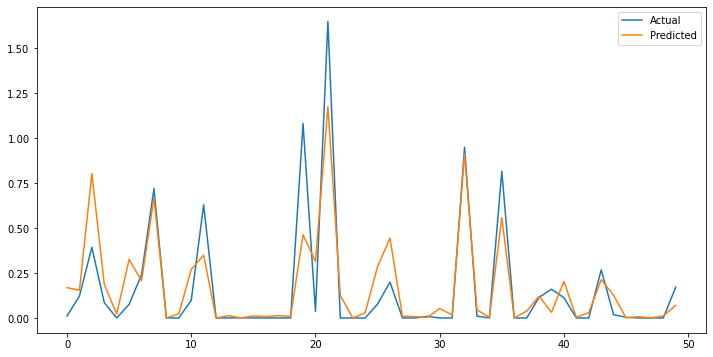

In [70]:
plot_predictions(y_test, y_test_pred, 50)

In [66]:
dump(lin_reg, "models/lin_reg.joblib")

['models/lin_reg.joblib']

In [60]:
# Learning curves

### Polynomial Regression

In [64]:
# Polynomial Regression with different degrees
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone

degrees = [2, 3, 4, 5, 6, 7]
best_score = np.inf
best_degree = 0
poly_regs = {}

for degree in degrees:
    new_num_pipeline = clone(num_pipeline)
    poly_features = PolynomialFeatures(degree=degree)
    new_num_pipeline.steps.append(["poly_features", poly_features])
    new_preprocessing = ColumnTransformer([
        ("num", new_num_pipeline, data_num_ix),
        ("cat", cat_pipline, data_cat_ix)
    ])
    poly_reg = Pipeline([
        ("preprocessing", new_preprocessing),
        ("lin_reg", TransformedTargetRegressor(LinearRegression(n_jobs=-1), transformer=sqrt_transformer))
    ])
    scores = -cross_val_score(poly_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
    print(f"Polynomial Regression degree {degree} cross validation MAE: ", scores.mean())
    poly_reg.fit(X_train, y_train)
    poly_regs[f"poly_reg_{degree}"] = poly_reg
    y_train_pred = poly_reg.predict(X_train)
    mae = mean_absolute_error(y_train, y_train_pred)
    print(f"Polynomial Regression degree {degree} MAE on training set: ", mae)
    y_test_pred = poly_reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    print(f"Polynomial Regression degree {degree} MAE on test set: ", mae)
    if scores.mean() < best_score:
        best_score = scores.mean()
        best_degree = degree

print("Best degree for polynomial regression: ", best_degree)

Polynomial Regression degree 2 cross validation MAE:  0.09700062397931106
Polynomial Regression degree 2 MAE on training set:  0.09582034914155992
Polynomial Regression degree 2 MAE on test set:  0.10048563783406841
Polynomial Regression degree 3 cross validation MAE:  0.09155271241123689
Polynomial Regression degree 3 MAE on training set:  0.08888266892943349
Polynomial Regression degree 3 MAE on test set:  0.09296364418436823
Polynomial Regression degree 4 cross validation MAE:  0.08879546744317426
Polynomial Regression degree 4 MAE on training set:  0.08291003661614915
Polynomial Regression degree 4 MAE on test set:  0.08958877672626718
Polynomial Regression degree 5 cross validation MAE:  0.08573543048267443
Polynomial Regression degree 5 MAE on training set:  0.0726214044519368
Polynomial Regression degree 5 MAE on test set:  0.0832342789602684
Polynomial Regression degree 6 cross validation MAE:  0.09380879628110497
Polynomial Regression degree 6 MAE on training set:  0.057581551

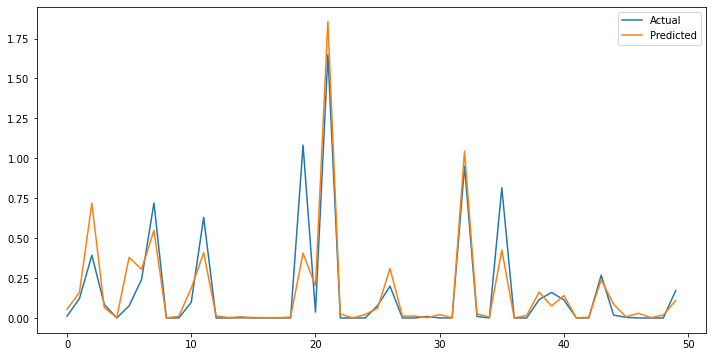

In [62]:
poly_reg = poly_regs[f"poly_reg_{best_degree}"]
plot_predictions(y_test, poly_reg.predict(X_test), 50)

In [71]:
dump(poly_reg, "models/poly_reg.joblib")

['models/poly_reg.joblib']

### Random Forest

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("forest_reg", RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = [
    {
        "forest_reg__n_estimators": [150, 200, 250], 
        "forest_reg__max_features": [25, 30],
        "forest_reg__max_depth": [25, 30, 35],
        "forest_reg__min_samples_split": [3, 5, 7],
    },
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print("Random Forest best parameters: ", grid_search.best_params_)
print("Random Forest best score: ", -grid_search.best_score_)

Random Forest best parameters:  {'forest_reg__max_depth': 35, 'forest_reg__max_features': 30, 'forest_reg__min_samples_split': 3, 'forest_reg__n_estimators': 250}
Random Forest best score:  0.0704865855325009


In [84]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest_reg__max_depth,param_forest_reg__max_features,param_forest_reg__min_samples_split,param_forest_reg__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
47,7.243866,0.242190,0.264264,0.066916,35,30,3,250,"{'forest_reg__max_depth': 35, 'forest_reg__max...",-0.069068,-0.071376,-0.066221,-0.073106,-0.072662,-0.070487,0.002553,1
29,7.878038,0.717613,0.168384,0.050442,30,30,3,250,"{'forest_reg__max_depth': 30, 'forest_reg__max...",-0.069088,-0.071413,-0.066224,-0.073159,-0.072702,-0.070517,0.002570,2
46,6.774605,0.971249,0.180360,0.090034,35,30,3,200,"{'forest_reg__max_depth': 35, 'forest_reg__max...",-0.069227,-0.071669,-0.066311,-0.072894,-0.072704,-0.070561,0.002494,3
28,5.548182,0.428028,0.144962,0.055615,30,30,3,200,"{'forest_reg__max_depth': 30, 'forest_reg__max...",-0.069269,-0.071766,-0.066317,-0.072944,-0.072756,-0.070610,0.002515,4
45,4.531218,0.426614,0.076331,0.011521,35,30,3,150,"{'forest_reg__max_depth': 35, 'forest_reg__max...",-0.069656,-0.071365,-0.066702,-0.072646,-0.072693,-0.070612,0.002247,5


In [85]:
model = grid_search.best_estimator_
feature_importances = model["forest_reg"].feature_importances_
sorted(zip(feature_importances, model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.3756798883236439, 'num__humidity_relative'),
 (0.07420275240865748, 'num__temp'),
 (0.0606951864699499, 'num__cloudiness'),
 (0.05702762362924975, 'cat__hour_12'),
 (0.05465814256784998, 'cat__hour_13'),
 (0.05221361780252458, 'cat__hour_11'),
 (0.04138550777334033, 'cat__hour_14'),
 (0.036256428962314846, 'cat__hour_10'),
 (0.03375909456482608, 'num__sunset'),
 (0.029156022529247913, 'num__sunrise'),
 (0.028897462990516456, 'cat__hour_15'),
 (0.025475489634564107, 'num__pressure'),
 (0.0219753454964112, 'cat__hour_16'),
 (0.017228210344935227, 'num__sun_noon'),
 (0.015810597724676374, 'cat__hour_9'),
 (0.013613755167839171, 'cat__hour_18'),
 (0.012310707203571311, 'cat__hour_19'),
 (0.012272066988242037, 'cat__hour_17'),
 (0.004382154995225696, 'cat__hour_8'),
 (0.004365343244401968, 'cat__hour_20'),
 (0.0034086969023398267, 'cat__month_5'),
 (0.0019558083932507252, 'cat__hour_21'),
 (0.001866641902706605, 'cat__day_3'),
 (0.0016706918563086026, 'cat__month_4'),
 (0.00162173076808

In [86]:
model = grid_search.best_estimator_
y_test_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print("Random Forest RMSE on test set: ", rmse)
print("Random Forest MAE on test set: ", mae)

Random Forest RMSE on test set:  0.15880998067321087
Random Forest MAE on test set:  0.07241473703803954


In [87]:
preds = model.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("Random Forest RMSE on train set: ", mae)

Random Forest RMSE on train set:  0.026441447387499435


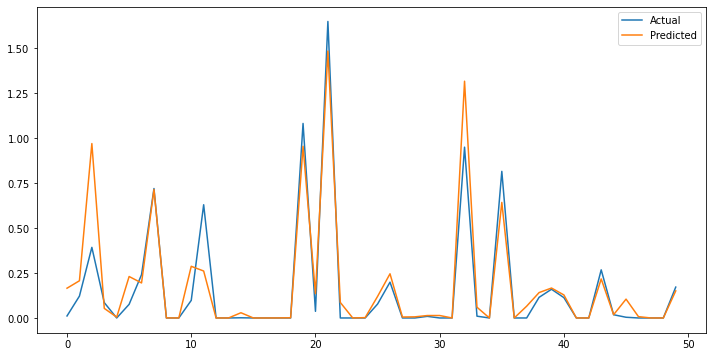

In [88]:
plot_predictions(y_test, y_test_pred, 50)

In [90]:
dump(model, "models/random_forest.joblib")

['models/random_forest.joblib']

### LinearSVR

In [82]:
from sklearn.svm import LinearSVR

svm_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("svm_reg", TransformedTargetRegressor(LinearSVR(random_state=42, dual="auto", max_iter=1000000)))
])

param_grid = [
    {"svm_reg__regressor__C": [0.5, 1, 2], "svm_reg__regressor__epsilon": [0.05, 0.1, 0.5]}
]

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print("SVM best parameters: ", grid_search.best_params_)
print("SVM best MAE score: ", -grid_search.best_score_)

SVM best parameters:  {'svm_reg__regressor__C': 0.5, 'svm_reg__regressor__epsilon': 0.05}
SVM best MAE score:  0.16616309114534658


### SVR

In [358]:
from sklearn.svm import SVR

degree = 3

svr = Pipeline([
    ("preprocessing", new_preprocessing),
    ("svr", TransformedTargetRegressor(SVR(kernel="poly", degree=degree), transformer=sqrt_transformer))
])
param_grid = [
    {"svr__regressor__C": [0.1, 1, 10], "svr__regressor__epsilon": [0.1, 1, 10]}
]
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
score = -grid_search.best_score_
print(f"SVR poly degree {degree} best parameters: ", grid_search.best_params_)
print(f"Polynomial Regression degree {degree} cross validation RMSE: ", score)
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
print(f"Polynomial Regression degree {degree} RMSE on training set: ", rmse)
y_test_pred = poly_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Polynomial Regression degree {degree} RMSE on test set: ", rmse)
